In [2]:
#import libraries
import numpy as np
import pandas as pd
from pandas import concat
import matplotlib.pyplot as plt
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import string
import yfinance as yf
from scipy import stats

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


**GameStop Time Series Forecasting**

In [79]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'GME'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
# Using 'max' for the entire period of stock trading
ticker_df = tickerData.history(period='max', start="2021-01-04", end="2021-12-31")


In [80]:
ticker_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04 00:00:00-05:00,4.7500,4.7750,4.2875,4.3125,40090000,0.0,0.0
2021-01-05 00:00:00-05:00,4.3375,4.5200,4.3075,4.3425,19846000,0.0,0.0
2021-01-06 00:00:00-05:00,4.3350,4.7450,4.3325,4.5900,24224800,0.0,0.0
2021-01-07 00:00:00-05:00,4.6175,4.8625,4.5050,4.5200,24517200,0.0,0.0
2021-01-08 00:00:00-05:00,4.5450,4.5750,4.2700,4.4225,25928000,0.0,0.0


In [81]:
ticker_df.shape

(251, 7)

In [82]:
ticker_df.reset_index(drop=False,inplace=True)
ticker_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-01-04 00:00:00-05:00,4.7500,4.7750,4.2875,4.3125,40090000,0.0,0.0
1,2021-01-05 00:00:00-05:00,4.3375,4.5200,4.3075,4.3425,19846000,0.0,0.0
2,2021-01-06 00:00:00-05:00,4.3350,4.7450,4.3325,4.5900,24224800,0.0,0.0
3,2021-01-07 00:00:00-05:00,4.6175,4.8625,4.5050,4.5200,24517200,0.0,0.0
4,2021-01-08 00:00:00-05:00,4.5450,4.5750,4.2700,4.4225,25928000,0.0,0.0


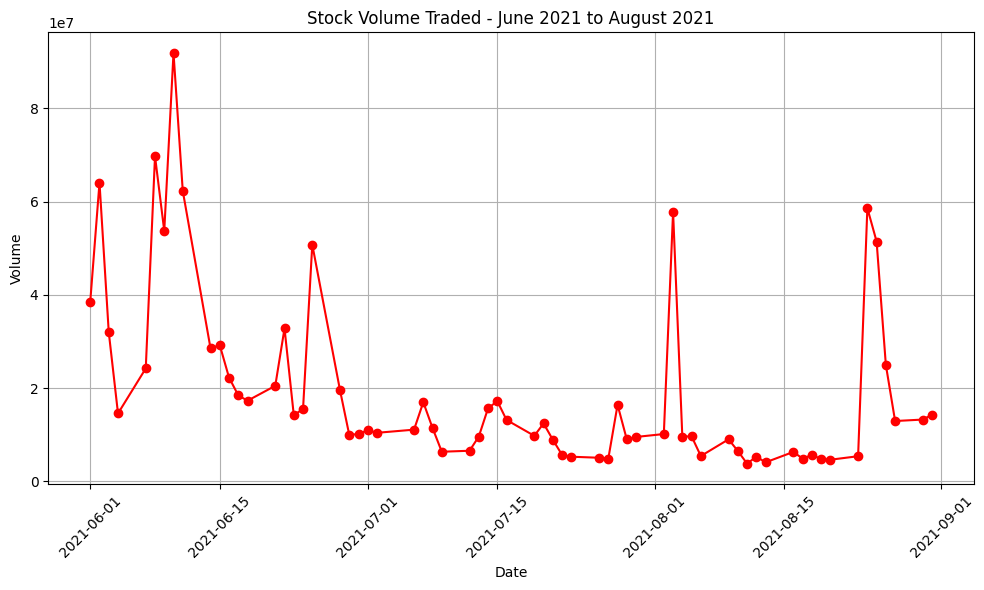

In [83]:
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])

# Filtering the DataFrame for June 2021 to August 2021
filtered_extended_df = ticker_df[(ticker_df['Date'] >= '2021-06-01') & (ticker_df['Date'] <= '2021-08-31')]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_extended_df['Date'], filtered_extended_df['Volume'], marker='o', linestyle='-', color='red')
plt.title('Stock Volume Traded - June 2021 to August 2021')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


- The x-axis represents time, with dates ranging from June 2021 to August 2021.
- The y-axis represents the volume of stock traded, scaled to 1e7 (10 million) units.

1.   There are noticeable spikes in trading volume at several points throughout the period, which could correspond to specific events or announcements related to the stock.

2.   The trading volume appears to have several days with particularly high activity, interspersed with periods of relatively lower volume.

3. There is no clear upward or downward trend in trading volume over the period; instead, the volume fluctuates significantly.

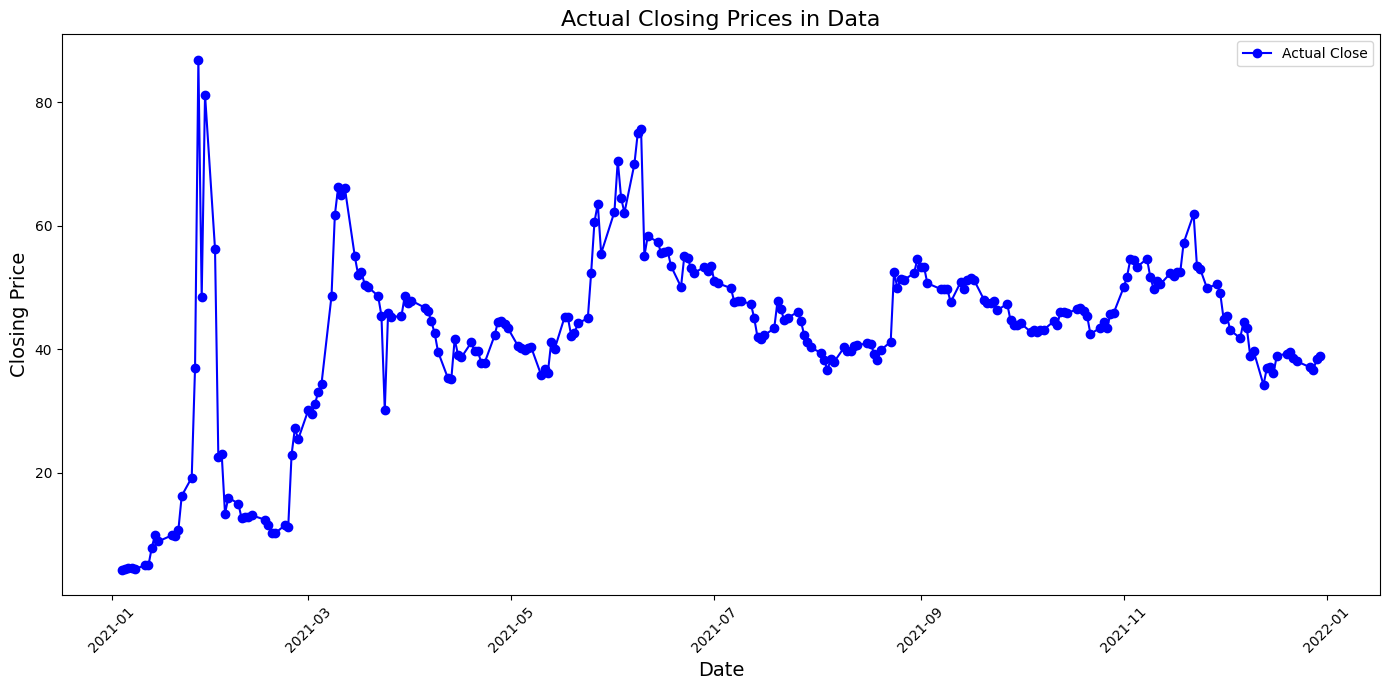

In [84]:
import matplotlib.pyplot as plt


# Ensure the 'Date' column is in datetime format for proper plotting
ticker_df['Date'] = ticker_df['Date'].dt.date

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(ticker_df['Date'], ticker_df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [85]:
ticker_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          251 non-null    object 
 1   Open          251 non-null    float64
 2   High          251 non-null    float64
 3   Low           251 non-null    float64
 4   Close         251 non-null    float64
 5   Volume        251 non-null    int64  
 6   Dividends     251 non-null    float64
 7   Stock Splits  251 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 15.8+ KB


In [86]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta

In [87]:
ticker_df.sort_values('Date', inplace=True)
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 1) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = ticker_df['Close'].values.reshape(-1, 1)
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)
scaled_close_prices.shape

(251, 1)

In [88]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [89]:
SEQUENCE_LENGTH = 40  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)

In [90]:
print(X.shape)
print(y.shape)

(211, 40, 1)
(211, 1)


In [91]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = pd.to_datetime('2021-05-31')
train_indices = ticker_df[ticker_df['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

<ipython-input-91-f6a41deab4bf>:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  train_indices = ticker_df[ticker_df['Date'] <= TRAIN_END_DATE].index


In [92]:
print(X_train.shape, y_train.shape)

(61, 40, 1) (61, 1)


In [93]:
# Define the LSTM model
model = Sequential([
    LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(60, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=19, batch_size=16)

Epoch 1/19
4/4 [==============================] - 6s 34ms/step - loss: 0.1718
Epoch 2/19
4/4 [==============================] - 0s 34ms/step - loss: 0.0392
Epoch 3/19
4/4 [==============================] - 0s 37ms/step - loss: 0.0436
Epoch 4/19
4/4 [==============================] - 0s 32ms/step - loss: 0.0153
Epoch 5/19
4/4 [==============================] - 0s 36ms/step - loss: 0.0240
Epoch 6/19
4/4 [==============================] - 0s 33ms/step - loss: 0.0213
Epoch 7/19
4/4 [==============================] - 0s 34ms/step - loss: 0.0157
Epoch 8/19
4/4 [==============================] - 0s 34ms/step - loss: 0.0153
Epoch 9/19
4/4 [==============================] - 0s 33ms/step - loss: 0.0147
Epoch 10/19
4/4 [==============================] - 0s 40ms/step - loss: 0.0128
Epoch 11/19
4/4 [==============================] - 0s 33ms/step - loss: 0.0130
Epoch 12/19
4/4 [==============================] - 0s 34ms/step - loss: 0.0128
Epoch 13/19
4/4 [==============================] - 0s 33ms/st

The model's loss decreases from 0.1718 to 0.0105 over the course of training, which is a good sign. It indicates that the model is learning from the training data and improving its predictions with each epoch.

In [94]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [95]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

In [96]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})


1/1 [==============================] - 0s 34ms/step


In [97]:
# Continue from the previous predictions_df creation code
# Ensure the 'Date' columns in both DataFrames are in the same format
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(ticker_df[['Date', 'Close']], on='Date', how='inner')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

predictions_with_actuals_df.head()

,Date,Predicted_Close,Actual_Close
0,2021-06-01,45.638165,62.255001
1,2021-06-02,46.175461,70.559998
2,2021-06-03,46.461826,64.544998
3,2021-06-04,46.595558,62.090000
4,2021-06-07,46.638401,70.002502


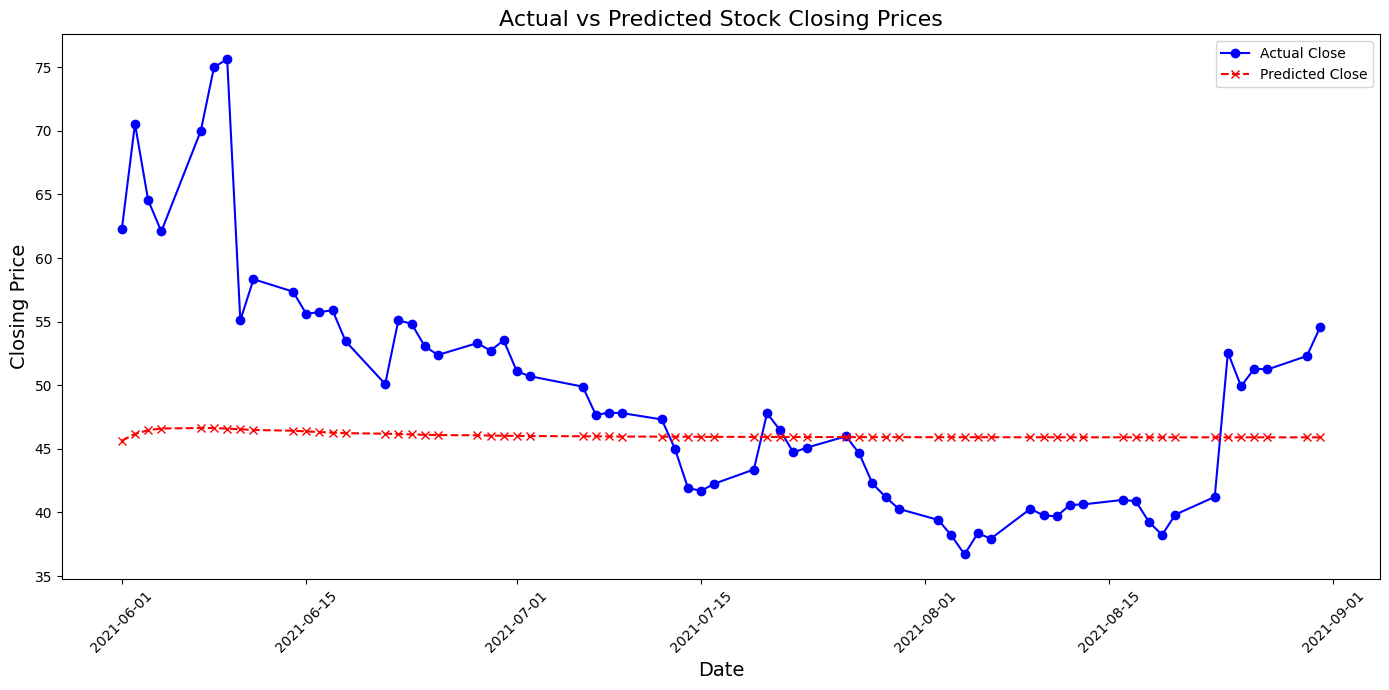

In [98]:

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

**GameStop - Sentiment Analysis**

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
df_GME_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rGME_dataset_features.csv')

<ipython-input-100-f1e3a3b886ee>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_GME_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rGME_dataset_features.csv')


In [101]:
df_GME_data.head()

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1,TitsDownOnly,9,44200,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1,zoomermoney,1,44200,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1,TitsDownOnly,6,44201,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1,dontforgettolive,4,44201,NaN,-0.2960,...,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1,nicky94,10,44202,NaN,0.0000,...,0,0,0,1,0,0,0,0,0,0


In [102]:
df_GME_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033236 entries, 0 to 1033235
Data columns (total 74 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Unnamed: 0      1033236 non-null  int64  
 1   id              1033236 non-null  object 
 2   title           1033236 non-null  object 
 3   url             1033236 non-null  object 
 4   score           1033236 non-null  int64  
 5   author          1033236 non-null  object 
 6   num_comments    1033236 non-null  int64  
 7   date            1033236 non-null  int64  
 8   flair           1006516 non-null  object 
 9   compound        1033236 non-null  float64
 10  neg             1033236 non-null  float64
 11  neu             1033236 non-null  float64
 12  pos             1033236 non-null  float64
 13  spacy_title     1033236 non-null  object 
 14  clean_text      1030177 non-null  object 
 15  char_count      1033236 non-null  int64  
 16  word_count      1033236 non-null  in

In [103]:
# Dropping the 'Unnamed: 0' column from the DataFrame
df_GME_data.drop(columns=['Unnamed: 0'], inplace=True)

In [104]:
# Convert the 'date' column to a proper datetime format
# Assuming the date is in Excel serial date format

def excel_date_to_datetime(excel_serial_date):
    """Convert an Excel serial date to a datetime object."""
    return pd.to_datetime('1900-01-01') + pd.to_timedelta(excel_serial_date, 'D')

df_GME_data['Date'] = df_GME_data['date'].apply(excel_date_to_datetime)

In [105]:
# Adding a 'sentiment' column based on the highest value among 'neg', 'neu', 'pos'
df_GME_data['sentiment'] = df_GME_data[['neg', 'neu', 'pos']].idxmax(axis=1)

In [106]:
df_GME_data['dayOfWeek'] = pd.to_datetime(df_GME_data['Date']).dt.day_name()

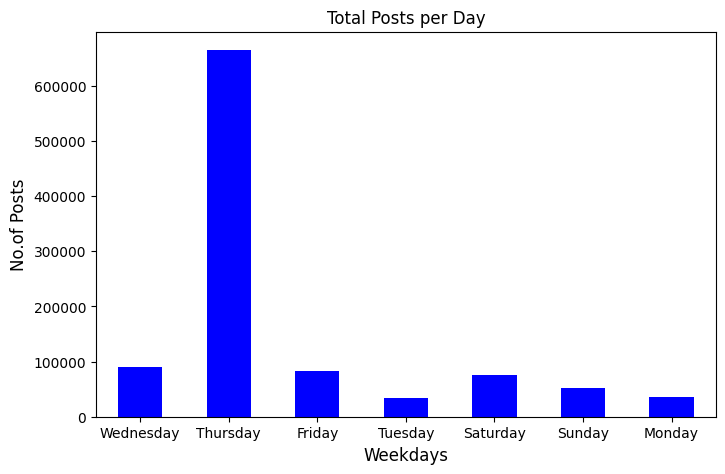

In [109]:
df_GME_data_day = df_GME_data['dayOfWeek']

plt.figure(figsize=(8,5))
df_GME_data_day = df_GME_data_day.groupby(df_GME_data_day,sort=False).count().plot.bar(color='blue')
plt.xlabel("Weekdays", fontsize=12)
plt.ylabel("No.of Posts", fontsize=12)
plt.xticks(rotation='horizontal')
plt.title('Total Posts per Day', fontsize=12)
plt.show()

In [110]:
import matplotlib.pyplot as plt

corr = df_GME_data.corr()
corr.style.background_gradient(cmap='coolwarm')

<ipython-input-110-3ce225e8a12e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_GME_data.corr()


,score,num_comments,date,compound,neg,neu,pos,char_count,word_count,word_count_cln,stopword_count,_NOUN,_VERB,_ADP,_ADJ,_DET,_PROPN,_INTJ,_PUNCT,_NUM,_PRON,_ADV,_PART,_amod,_ROOT,_punct,_advmod,_auxpass,_nsubjpass,_ccomp,_acomp,_neg,_nsubj,_aux,_agent,_det,_pobj,_prep,_csubj,_nummod,_attr,_acl,_relcl,_dobj,_pcomp,_xcomp,_cc,_conj,_mark,_prt,_compound,_dep,_advcl,_parataxis,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
score,1.000000,0.114631,-0.001569,0.001986,-0.000291,-0.000866,0.001198,0.009120,0.010075,0.010135,0.008786,0.001925,0.011991,0.002885,0.000914,-0.000073,0.000375,-0.000819,0.000505,0.010499,0.004730,0.002387,0.000754,0.001981,0.008979,0.006519,0.004586,0.000946,0.000862,0.007248,0.003720,0.007196,0.011473,0.009184,0.000272,0.002965,0.003786,0.003458,0.006877,0.009813,0.010530,0.005708,0.003083,0.011339,-0.000689,0.004870,0.003813,0.003566,0.009439,0.003235,-0.000058,0.001397,0.006922,-0.001725,0.003221,0.002296,0.001251,0.007727,-0.001113,0.001281,0.014659,0.003828,0.002099,0.002887
num_comments,0.114631,1.000000,0.004385,-0.006483,0.004829,0.001642,-0.005325,0.009671,0.009529,0.005966,0.006453,-0.009682,0.011227,-0.003070,0.004701,0.001789,0.024352,0.002769,-0.000019,0.007163,0.011165,-0.001779,0.001206,-0.009628,0.003159,0.020855,0.012232,-0.003267,-0.002831,0.006076,0.002700,0.004951,0.012582,0.019219,0.010757,-0.006768,-0.000815,-0.000566,0.003429,0.024805,0.005624,0.002524,-0.002936,0.002978,0.008570,-0.004320,0.004536,0.000512,0.008849,0.003027,0.015282,-0.008763,0.006694,-0.006346,-0.005548,0.002767,-0.003106,0.004758,-0.005370,0.001429,0.004595,0.003405,0.000804,-0.001096
date,-0.001569,0.004385,1.000000,0.000106,-0.036363,0.025365,-0.003054,-0.009908,-0.013326,-0.004696,-0.027887,-0.030371,-0.005344,-0.020691,-0.011128,0.011373,0.019091,-0.018694,0.012371,0.026326,0.035581,-0.015807,0.020842,-0.027325,0.003302,0.009815,-0.016261,0.009284,0.007869,-0.018591,-0.008007,-0.010309,-0.020304,0.002842,-0.001446,-0.045205,-0.016449,-0.019021,0.033347,0.015555,0.025066,-0.015341,-0.010066,0.006040,-0.027141,-0.011481,-0.034641,-0.028954,-0.002937,-0.012283,0.031175,-0.002966,-0.004973,-0.021178,-0.014025,0.026009,0.001747,0.036991,-0.020401,0.003383,0.035970,0.032417,0.019514,-0.003497
compound,0.001986,-0.006483,0.000106,1.000000,-0.504900,-0.304499,0.707906,0.205438,0.259191,0.281184,0.221794,0.235573,0.249465,0.139946,0.087437,0.001654,-0.070060,-0.099224,0.001908,0.037770,0.012330,0.129181,0.003096,0.195937,0.248519,0.194695,0.190274,0.011105,0.027545,0.155514,0.152658,0.084456,0.250696,0.194942,0.031090,0.169872,0.145138,0.093465,0.006155,0.024211,0.055716,0.083789,0.123338,0.249166,-0.118055,0.153277,0.173834,0.163788,0.087484,0.103799,-0.035198,0.062885,0.118417,0.136625,0.035371,-0.023467,0.153435,0.091143,0.156929,-0.092111,-0.007973,0.010272,0.058661,0.022716
neg,-0.000291,0.004829,-0.036363,-0.504900,1.000000,-0.499146,-0.142971,-0.054308,-0.057881,-0.050475,-0.066496,-0.040450,-0.074489,-0.051832,0.019094,0.000168,-0.016903,0.389869,-0.002857,-0.025813,0.014287,-0.042612,-0.003176,0.000737,-0.008027,-0.026318,-0.072370,0.003179,0.012961,-0.038015,0.009257,-0.003550,-0.073325,-0.075940,-0.026560,-0.042923,-0.055229,-0.026595,0.004618,-0.038520,-0.046300,0.015364,-0.057703,-0.042431,0.062813,-0.044102,-0.025979,-0.038092,-0.026467,-0.002092,-0.003460,-0.017345,-0.053910,-0.035823,-0.036968,0.249954,-0.054318,-0.038366,-0.052270,0.011746,0.002518,0.003149,-0.028390,-0.015702
neu,-0.000866,0.001642,0.025365,-0.304499,-0.499146,1.000000,-0.786252,0.022840,-0.014364,-0.059419,0.032079,-0.069828,-0.002195,0.019476,-0.040013,-0.001576,0.110043,-0.206638,0.001515,0.007715,0.004138,-0.040906,0.001854,-0.073032,-0.133445,-0.032003,0.014878,0.027913,0.009986,-0.046477,-0.083917,-0.050920,-0.013071,0.044196,0.024793,0.001330,0.022651,0.025039,-0.007185,0.061786,0.045491,-0.061306,0.067646,-0.088868,0.023371,0.029527,-0.011873,-0.004400,0.052657,0.014495,0.068613,-0.007629,0.064063,-0.007042

 **Analysis for June 2021 to August 2021**

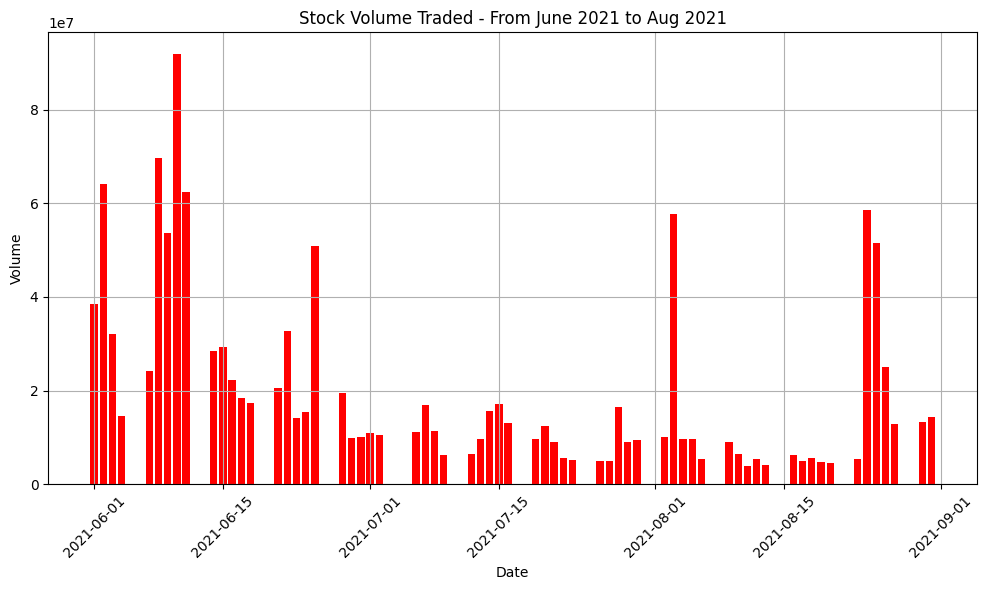

In [121]:
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])

# Filtering the DataFrame for June 2021 to August 2021
filtered_extended_df = ticker_df[(ticker_df['Date'] >= '2021-06-01') & (ticker_df['Date'] <= '2021-08-31')]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(filtered_extended_df['Date'], filtered_extended_df['Volume'], color='red')
plt.title('Stock Volume Traded - From June 2021 to Aug 2021')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



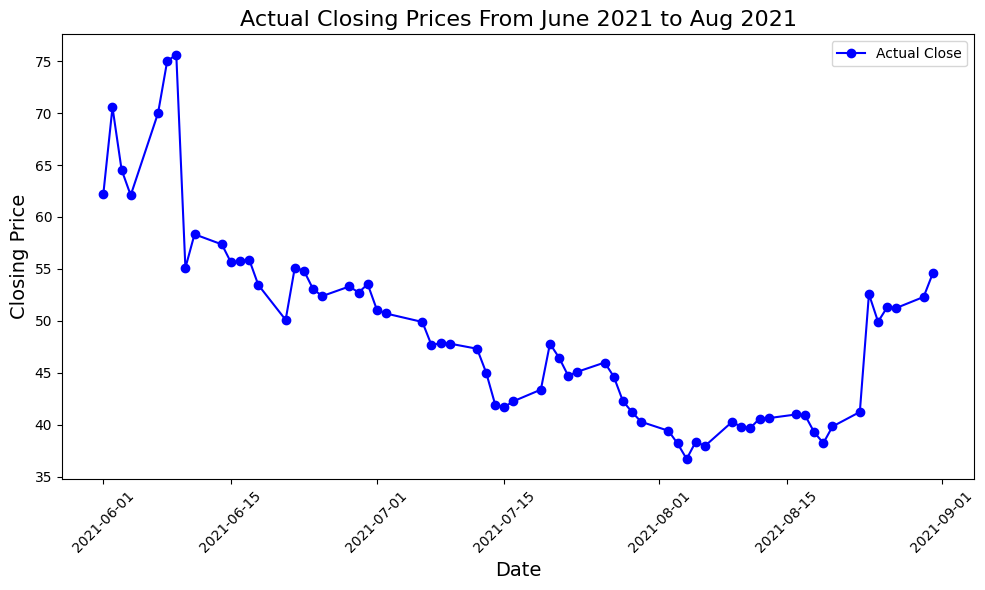

In [123]:
import matplotlib.pyplot as plt


# Ensure the 'Date' column is in datetime format for proper plotting

filtered_extended_df = ticker_df[(ticker_df['Date'] >= '2021-06-01') & (ticker_df['Date'] <= '2021-08-31')]


# Setting the plot size for better readability
plt.figure(figsize=(10, 6))

# Plotting the actual closing prices in the training period
plt.plot(filtered_extended_df['Date'], filtered_extended_df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices From June 2021 to Aug 2021', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [111]:
# Filtering the DataFrame for June 2021 to August 2021
df_GME_data_filtered = df_GME_data[(df_GME_data['Date'] >= '2021-06-01') & (df_GME_data['Date'] <= '2021-08-31')]

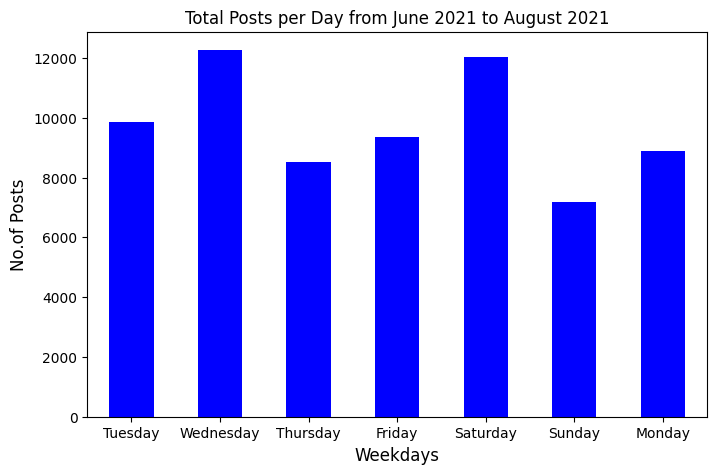

In [112]:
df_GME_data_day = df_GME_data_filtered['dayOfWeek']

plt.figure(figsize=(8,5))
df_GME_data_day = df_GME_data_day.groupby(df_GME_data_day,sort=False).count().plot.bar(color='blue')
plt.xlabel("Weekdays", fontsize=12)
plt.ylabel("No.of Posts", fontsize=12)
plt.xticks(rotation='horizontal')
plt.title('Total Posts per Day from June 2021 to August 2021', fontsize=12)
plt.show()

- There's a noticeable variation in posting activity throughout the week. Wednesday appears to have the highest number of posts, while Sunday has the lowest.

- The peak on Wednesday suggests that users may be more active in the middle of the week. This could be due to various factors, such as market events or weekly cycles in user activity.

- A drop in the number of posts during the weekend (Saturday and Sunday) is evident. This is typical as financial markets are closed, and there might be less news or fewer developments to discuss.

In [113]:
df_GME_data_filtered_cleaned = df_GME_data_filtered.copy()
df_GME_data_filtered_cleaned.dropna(subset='clean_text',inplace=True)

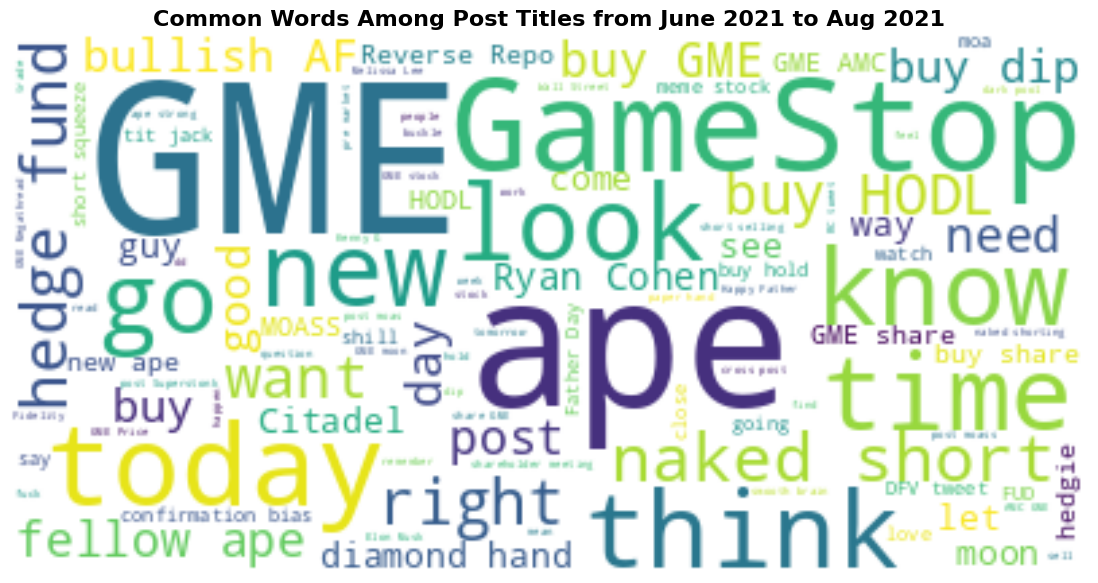

In [114]:
from wordcloud import WordCloud

# FOR TITLE POSTS
title_text = " ".join(review for review in df_GME_data_filtered_cleaned['clean_text'])

# Create a word cloud image
wc = WordCloud(background_color="white", max_words=100, contour_width=3)

# Generate a wordcloud
wc.generate(title_text)

# show
plt.figure(figsize=[15,7])
plt.imshow(wc, interpolation='bilinear')
plt.title('Common Words Among Post Titles from June 2021 to Aug 2021',fontsize=16,fontweight='bold')
plt.axis("off")
plt.show()

- The most prominent words include "GameStop", "APE", "today", "think", "know", and "time". This suggests that discussions frequently revolved around GameStop and possibly the "ape" term, which is often used within certain investment communities to refer to members of that group.

-  There are several terms that are contextually relevant to the GameStop phenomenon, such as "HODL" (a term used in the cryptocurrency community to mean hold the investment long term), "buy", "dip" (which could refer to buying the stock when its price has dropped), "short" (possibly referring to short selling or the short squeeze that occurred), and "MOASS" (which stands for "Mother Of All Short Squeezes").

- Words like "bullish", "fund", "naked", "share", "diamond", and "hand" suggest discussions about market sentiment, investment strategies, and possibly reactions to market manipulation ("naked" could refer to naked short selling).

- The presence of words like "ape", "moon", and "diamond hand" indicates the use of community-specific jargon and memes, which were prevalent in the social media discourse around the GameStop trading frenzy.

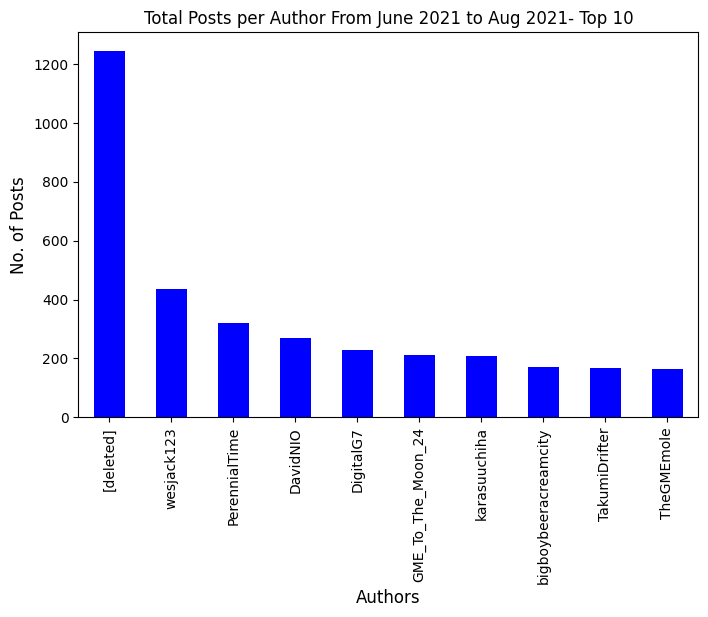

In [124]:
# Count the number of posts per author
author_counts = df_GME_data_filtered['author'].value_counts()

# Select the top 10 authors
top_10_authors = author_counts.head(10)

# Plotting
plt.figure(figsize=(8, 5))
top_10_authors.plot.bar(color='blue')
plt.xlabel("Authors", fontsize=12)
plt.ylabel("No. of Posts", fontsize=12)
plt.xticks(rotation='vertical')  # Ensures authors' names are readable
plt.title('Total Posts per Author From June 2021 to Aug 2021- Top 10', fontsize=12)
plt.show()

**Analysis for Jan 2021**

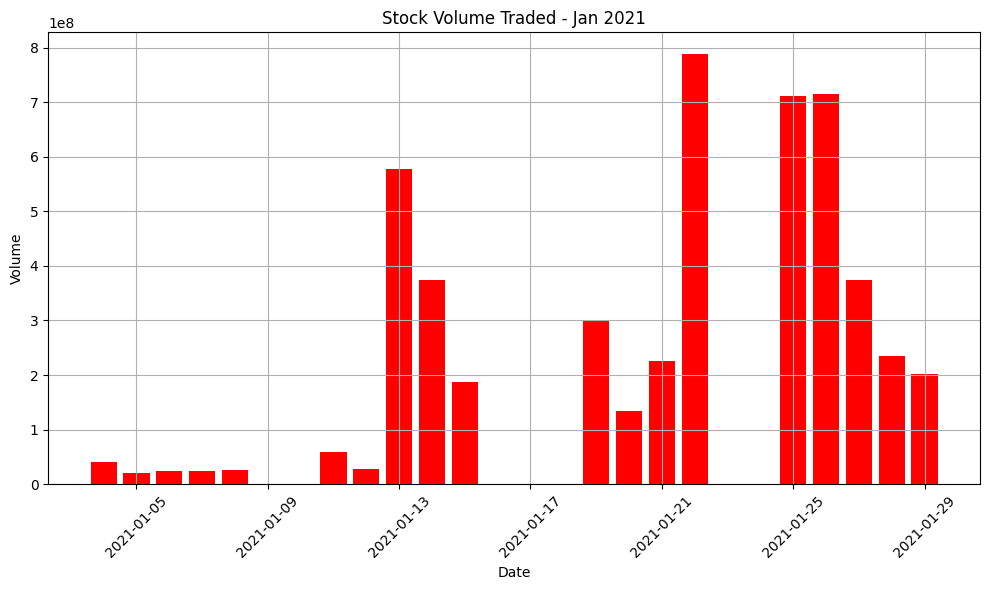

In [116]:
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])

# Filtering the DataFrame for Jan 2021
filtered_extended_df = ticker_df[(ticker_df['Date'] >= '2021-01-01') & (ticker_df['Date'] <= '2021-01-31')]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(filtered_extended_df['Date'], filtered_extended_df['Volume'], color='red')
plt.title('Stock Volume Traded - Jan 2021')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



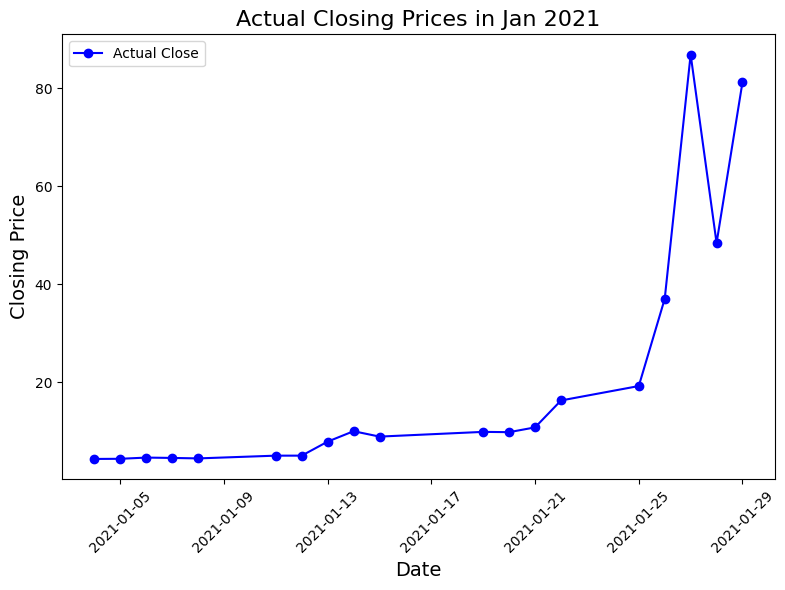

In [119]:
import matplotlib.pyplot as plt


# Ensure the 'Date' column is in datetime format for proper plotting

filtered_extended_df = ticker_df[(ticker_df['Date'] >= '2021-01-01') & (ticker_df['Date'] <= '2021-01-31')]


# Setting the plot size for better readability
plt.figure(figsize=(8, 6))

# Plotting the actual closing prices in the training period
plt.plot(filtered_extended_df['Date'], filtered_extended_df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Jan 2021', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [43]:
# Filtering the DataFrame for Jan 2021
df_GME_data_jan = df_GME_data[(df_GME_data['Date'] >= '2021-01-01') & (df_GME_data['Date'] <= '2021-01-31')]

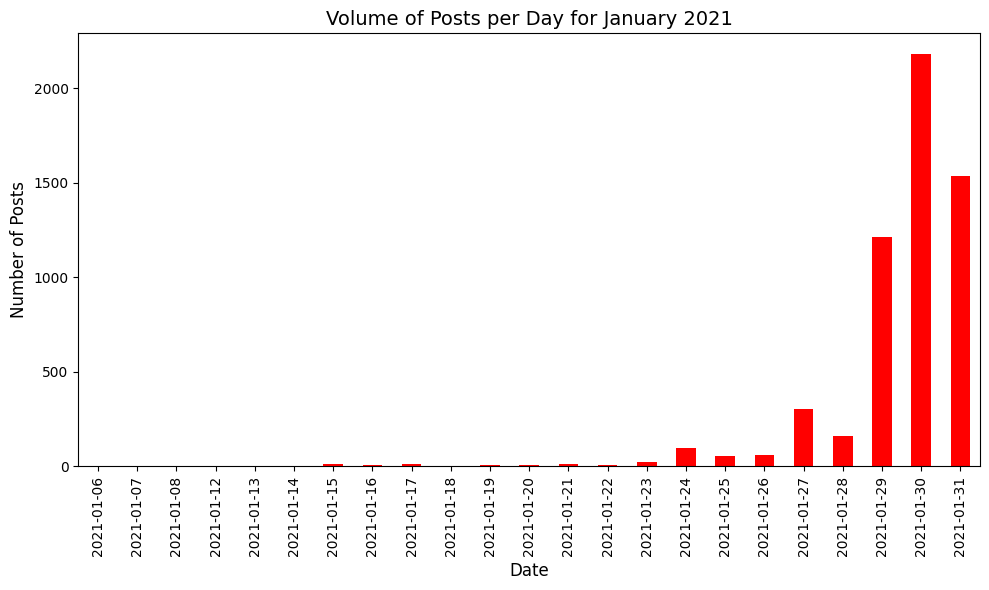

In [44]:
# Group by Date and count the number of posts
posts_per_day = df_GME_data_jan.groupby(df_GME_data_jan['Date'].dt.date).count()['clean_text']

# Plotting
plt.figure(figsize=(10, 6))
posts_per_day.plot(kind='bar', color='red')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.title("Volume of Posts per Day for January 2021", fontsize=14)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

- There is a significant increase in the volume of posts towards the end of the month, with the last few days showing the highest numbers, especially a sharp spike on the last day presented.
- The early and middle parts of the month have a relatively low and stable number of posts per day.
- This pattern could correlate with specific events or developments that occurred during that time, possibly driving increased posting activity. Given the context of January 2021 and the known events surrounding GameStop, the surge in posts towards the end of the month likely corresponds to the heightened interest and activity due to the stock's significant price movements and media attention.

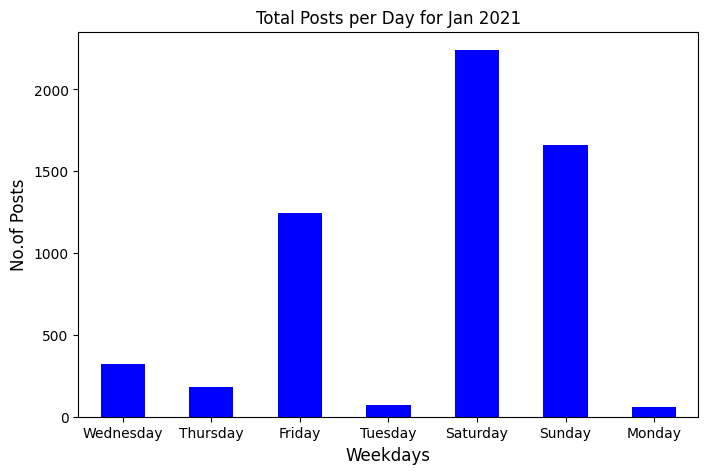

In [45]:
df_GME_data_day = df_GME_data_jan['dayOfWeek']

plt.figure(figsize=(8,5))
df_GME_data_day = df_GME_data_day.groupby(df_GME_data_day,sort=False).count().plot.bar(color='blue')
plt.xlabel("Weekdays", fontsize=12)
plt.ylabel("No.of Posts", fontsize=12)
plt.xticks(rotation='horizontal')
plt.title('Total Posts per Day for Jan 2021', fontsize=12)
plt.show()

- The number of posts varies significantly throughout the week, with the highest posting activity occurring on Saturday, followed by Monday. This could suggest that users are more active on the platform during the weekends.

- There's a noticeable dip in posting activity on Wednesday, Thursday, and Friday compared to the other days. This pattern is somewhat unusual for typical social media activity, which often sees a steady buildup over the week.

- The increase in posts on Saturday might indicate a trend of users being more engaged over the weekend. However, this is somewhat contradicted by Sunday having fewer posts than Saturday, which may suggest that a specific event on the prior Saturday caused the spike in activity.

In [46]:
df_GME_data_jan_cleaned = df_GME_data_jan.copy()
df_GME_data_jan_cleaned.dropna(subset='clean_text',inplace=True)

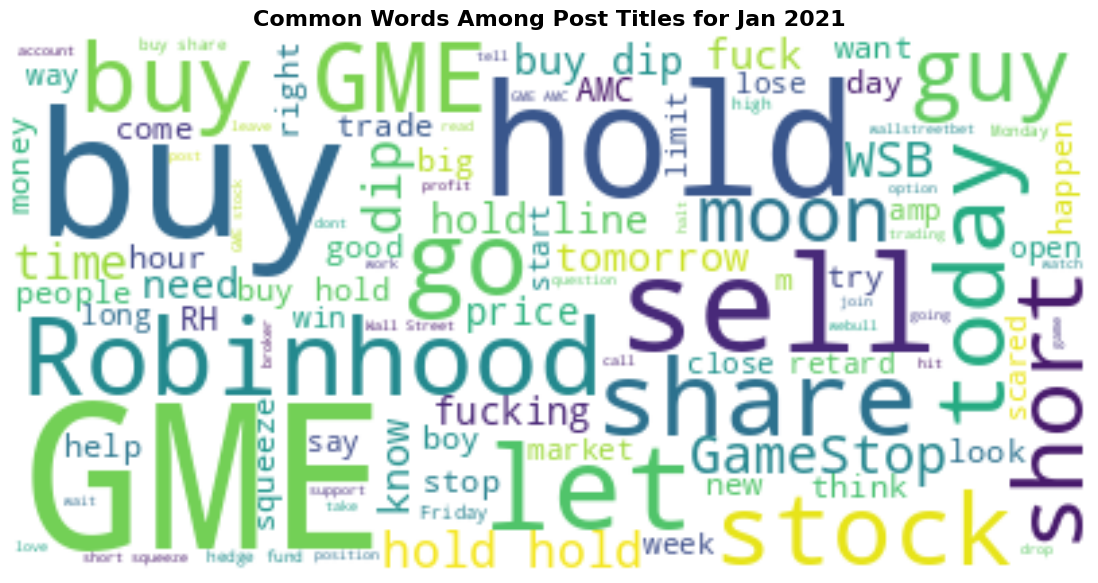

In [47]:
from wordcloud import WordCloud

# FOR TITLE POSTS
title_text = " ".join(review for review in df_GME_data_jan_cleaned['clean_text'])

# Create a word cloud image
wc = WordCloud(background_color="white", max_words=100, contour_width=3)

# Generate a wordcloud
wc.generate(title_text)

# show
plt.figure(figsize=[15,7])
plt.imshow(wc, interpolation='bilinear')
plt.title('Common Words Among Post Titles for Jan 2021',fontsize=16,fontweight='bold')
plt.axis("off")
plt.show()

- The terms "GameStop," "buy," "stock," "hold," and "sell" are prominently featured, indicating they were central themes in the discussions. This aligns with the events of January 2021, when GameStop's stock experienced unprecedented volatility and trading volumes, partly driven by discussions on social media platforms and forums.

- Words like "moon," "diamond," and "hold" reflect the community's slang and sentiment, with "moon" often signifying an expectation of stock prices rising significantly and "diamond" referring to a strong resolve to hold onto the stock (Diamond Hands).

- Words like "short," "squeeze," "dip," and "Robinhood" are related to trading strategies and actions. "Short squeeze" refers to the situation where a stock's price increases rapidly as short sellers cover their positions, and "dip" suggests buying the stock when its price has dropped.

- The presence of expletives and terms like "fuck" and "scared" indicate the emotional intensity of the discussions. This suggests a turbulent market environment with strong emotional reactions from individual investors.

- Terms like "market," "price," "hour," "tomorrow," and "week" indicate a focus on the immediacy of the market's movements and short-term planning.

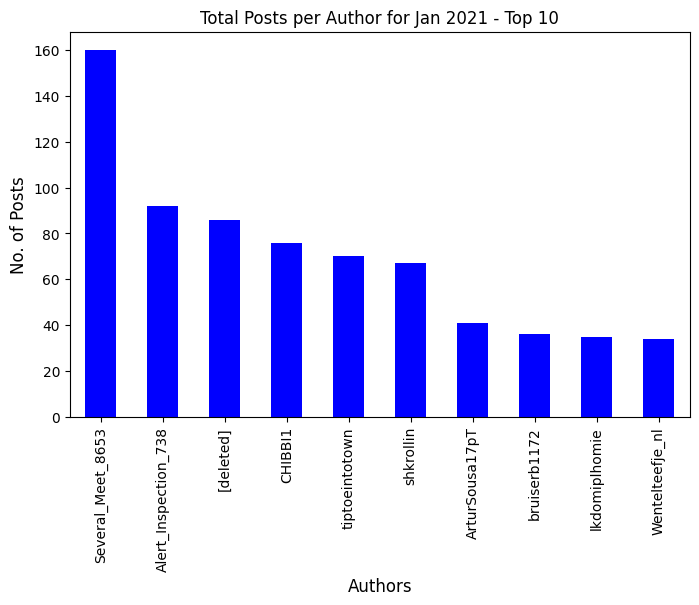

In [48]:
# Count the number of posts per author
author_counts = df_GME_data_jan['author'].value_counts()

# Select the top 10 authors
top_10_authors = author_counts.head(10)

# Plotting
plt.figure(figsize=(8, 5))
top_10_authors.plot.bar(color='blue')
plt.xlabel("Authors", fontsize=12)
plt.ylabel("No. of Posts", fontsize=12)
plt.xticks(rotation='vertical')  # Ensures authors' names are readable
plt.title('Total Posts per Author for Jan 2021 - Top 10', fontsize=12)
plt.show()

**Infusion Model - LSTM and Sentiment Analysis**

In [49]:
# Calculating the compound daily sentiment score
df_daily_sentiment = df_GME_data.groupby('Date').agg({'compound': 'mean'}).reset_index()

In [50]:
df_daily_sentiment.head()

,Date,compound
0,2021-01-06,0.988900
1,2021-01-07,0.117950
2,2021-01-08,0.388850
3,2021-01-12,0.966700
4,2021-01-13,0.237925


In [51]:
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
df_daily_sentiment['Date'] = pd.to_datetime(df_daily_sentiment['Date'])

In [52]:
ticker_sentiment_df = pd.merge(ticker_df, df_daily_sentiment, on='Date', how='left')
ticker_sentiment_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,compound
0,2021-01-04,4.750000,4.775000,4.287500,4.312500,40090000,0.0,0.0,NaN
1,2021-01-05,4.337500,4.520000,4.307500,4.342500,19846000,0.0,0.0,NaN
2,2021-01-06,4.335000,4.745000,4.332500,4.590000,24224800,0.0,0.0,0.988900
3,2021-01-07,4.617500,4.862500,4.505000,4.520000,24517200,0.0,0.0,0.117950
4,2021-01-08,4.545000,4.575000,4.270000,4.422500,25928000,0.0,0.0,0.388850
...,...,...,...,...,...,...,...,...,...
246,2021-12-23,38.500000,38.750000,36.505001,38.035000,4222000,0.0,0.0,0.222480
247,2021-12-27,38.000000,38.154999,35.000000,37.077499,6454400,0.0,0.0,0.264347
248,2021-12-28,36.875000,39.352501,36.602501,36.615002,5324400,0.0,0.0,0.294618
249,2021-12-29,36.962502,38.872501,35.535000,38.482498,8149600,0.0,0.0,0.142411


In [53]:
ticker_sentiment_df['compound'].fillna(value=0,inplace=True)

In [54]:
ticker_sentiment_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,compound
0,2021-01-04,4.7500,4.7750,4.2875,4.3125,40090000,0.0,0.0,0.00000
1,2021-01-05,4.3375,4.5200,4.3075,4.3425,19846000,0.0,0.0,0.00000
2,2021-01-06,4.3350,4.7450,4.3325,4.5900,24224800,0.0,0.0,0.98890
3,2021-01-07,4.6175,4.8625,4.5050,4.5200,24517200,0.0,0.0,0.11795
4,2021-01-08,4.5450,4.5750,4.2700,4.4225,25928000,0.0,0.0,0.38885


In [55]:
# Assuming 'df' is your DataFrame
ticker_sentiment_df['Date'] = pd.to_datetime(ticker_sentiment_df['Date'])
ticker_sentiment_df.sort_values('Date', inplace=True)

# Extract 'Close' and 'compound' columns
close_compound = ticker_sentiment_df[['Close', 'compound']].values  # No need to reshape

# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_compound = scaler.fit_transform(close_compound)


In [56]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length, 0]  # Assuming the first column ('Close') is the target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys).reshape(-1, 1)

SEQUENCE_LENGTH = 40
X, y = create_sequences(scaled_close_compound, SEQUENCE_LENGTH)


In [57]:
TRAIN_END_DATE = '2021-05-31'
train_indices = ticker_sentiment_df[ticker_sentiment_df['Date'] <= TRAIN_END_DATE].index
X_train_merge, y_train_merge = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]


In [58]:
print(X_train_merge.shape, y_train_merge.shape)

(61, 40, 2) (61, 1)


In [59]:
model = Sequential([
    LSTM(60, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 2)),  # Input shape is [sequence_length, num_features]
    LSTM(60, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [60]:
model.fit(X_train_merge, y_train_merge, epochs=19, batch_size=16)


Epoch 1/19
4/4 [==============================] - 5s 60ms/step - loss: 0.1904
Epoch 2/19
4/4 [==============================] - 0s 62ms/step - loss: 0.0349
Epoch 3/19
4/4 [==============================] - 0s 57ms/step - loss: 0.0362
Epoch 4/19
4/4 [==============================] - 0s 60ms/step - loss: 0.0152
Epoch 5/19
4/4 [==============================] - 0s 62ms/step - loss: 0.0207
Epoch 6/19
4/4 [==============================] - 0s 65ms/step - loss: 0.0172
Epoch 7/19
4/4 [==============================] - 0s 59ms/step - loss: 0.0115
Epoch 8/19
4/4 [==============================] - 0s 67ms/step - loss: 0.0135
Epoch 9/19
4/4 [==============================] - 0s 68ms/step - loss: 0.0121
Epoch 10/19
4/4 [==============================] - 0s 64ms/step - loss: 0.0108
Epoch 11/19
4/4 [==============================] - 0s 43ms/step - loss: 0.0108
Epoch 12/19
4/4 [==============================] - 0s 39ms/step - loss: 0.0099
Epoch 13/19
4/4 [==============================] - 0s 36ms/st

In [61]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1), periods=66, freq='B')

last_sequence = X_train_merge[-1].reshape((1, SEQUENCE_LENGTH, 2))

predictions_sentiment = []
for i in range(len(business_days)):
    current_prediction = model.predict(last_sequence)[0]
    predictions_sentiment.append(current_prediction)
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1] = [current_prediction, last_sequence[0, -2, 1]]  # Update 'Close' and reuse last 'compound'

predicted_sentiment_prices = scaler.inverse_transform(np.column_stack((predictions_sentiment, np.zeros(len(predictions_sentiment)))))[:, 0]

predictions_sentiment_df = pd.DataFrame({
    'Date': business_days,
    'Infused Model Predicted Close': predicted_sentiment_prices
})


1/1 [==============================] - 0s 33ms/step


<ipython-input-61-8818eacc2065>:10: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  last_sequence[0, -1] = [current_prediction, last_sequence[0, -2, 1]]  # Update 'Close' and reuse last 'compound'


1/1 [==============================] - 0s 52ms/step


In [62]:
predictions_sentiment_df.head()

,Date,Infused Model Predicted Close
0,2021-06-01,47.930345
1,2021-06-02,48.225438
2,2021-06-03,48.317229
3,2021-06-04,48.265399
4,2021-06-07,48.085064


In [63]:
# Merge the predictions with the actual closing prices from 'df'
predictions_with_sentiment_df = predictions_sentiment_df.merge(predictions_with_actuals_df, on='Date', how='inner')

In [64]:
predictions_with_sentiment_df.head(10)

,Date,Infused Model Predicted Close,Predicted_Close,Actual_Close
0,2021-06-01,47.930345,46.277931,62.255001
1,2021-06-02,48.225438,46.930058,70.559998
2,2021-06-03,48.317229,47.306080,64.544998
3,2021-06-04,48.265399,47.504028,62.090000
4,2021-06-07,48.085064,47.590004,70.002502
5,2021-06-08,47.827003,47.608105,75.000000
6,2021-06-09,47.464100,47.587006,75.639999
7,2021-06-10,47.033416,47.545025,55.097500
8,2021-06-11,46.610025,47.493679,58.334999
9,2021-06-14,46.158623,47.439392,57.360001


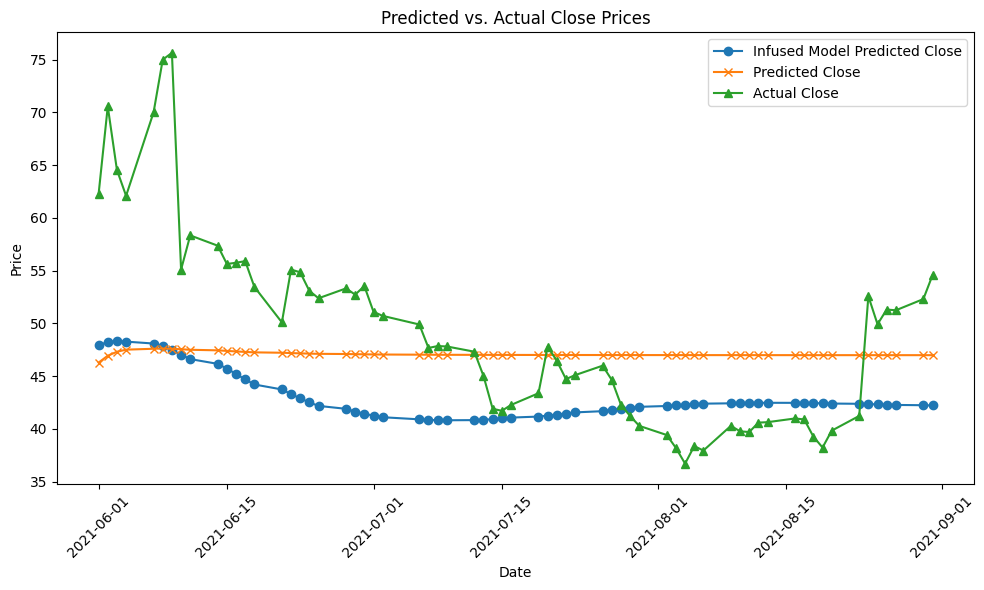

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

predictions_with_sentiment_df['Date'] = pd.to_datetime(predictions_with_sentiment_df['Date'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(predictions_with_sentiment_df['Date'], predictions_with_sentiment_df['Infused Model Predicted Close'], label='Infused Model Predicted Close', marker='o')
plt.plot(predictions_with_sentiment_df['Date'], predictions_with_sentiment_df['Predicted_Close'], label='Predicted Close', marker='x')
plt.plot(predictions_with_sentiment_df['Date'], predictions_with_sentiment_df['Actual_Close'], label='Actual Close', marker='^')

plt.title('Predicted vs. Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Infused Model Predicted Close (Blue Line with Circle Markers): This line represents the closing price as predicted by an "infused model," which may refer to a model that incorporates various data sources or advanced features. The line trends relatively flat, with minor fluctuations, indicating that the model's predictions do not vary widely over time.

Predicted Close (Orange Line with 'X' Markers): This line shows another set of predicted closing prices, possibly from a different model or prediction method. This line also trends relatively flat and follows closely with the Infused Model Predicted Close line, suggesting that both prediction models are providing similar outputs over the observed period.

Actual Close (Green Line with Triangle Markers): This line represents the actual closing prices. It shows more significant variation than the predicted lines, with noticeable peaks and troughs. The actual close prices exhibit two prominent spikes, indicating days when the closing price was much higher than the predicted values.

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Actual_Close vs Predicted_Close
mse_predicted = mean_squared_error(predictions_with_sentiment_df['Actual_Close'], predictions_with_sentiment_df['Predicted_Close'])
mae_predicted = mean_absolute_error(predictions_with_sentiment_df['Actual_Close'], predictions_with_sentiment_df['Predicted_Close'])
r2_predicted = r2_score(predictions_with_sentiment_df['Actual_Close'], predictions_with_sentiment_df['Predicted_Close'])

# 2. Actual_Close vs Infused Model Predicted Close
mse_infused = mean_squared_error(predictions_with_sentiment_df['Actual_Close'], predictions_with_sentiment_df['Infused Model Predicted Close'])
mae_infused = mean_absolute_error(predictions_with_sentiment_df['Actual_Close'], predictions_with_sentiment_df['Infused Model Predicted Close'])
r2_infused = r2_score(predictions_with_sentiment_df['Actual_Close'], predictions_with_sentiment_df['Infused Model Predicted Close'])

print("Evaluation Metrics for Predicted_Close:")
print(f"Mean Squared Error: {mse_predicted:.2f}")
print(f"Mean Absolute Error: {mae_predicted:.2f}")
print(f"R^2 Score: {r2_predicted:.2f}\n")

print("Evaluation Metrics for Infused Model Predicted Close:")
print(f"Mean Squared Error: {mse_infused:.2f}")
print(f"Mean Absolute Error: {mae_infused:.2f}")
print(f"R^2 Score: {r2_infused:.2f}")


Evaluation Metrics for Predicted_Close:
Mean Squared Error: 85.05
Mean Absolute Error: 7.18
R^2 Score: -0.03

Evaluation Metrics for Infused Model Predicted Close:
Mean Squared Error: 95.35
Mean Absolute Error: 7.68
R^2 Score: -0.15


Interpretation:

--- MSE and MAE: Both models have relatively high Mean Squared Error and Mean Absolute Error values, which indicate the average squared and absolute differences between the predicted and actual closing prices are substantial. The Infused Model has slightly higher MSE and MAE than the Predicted_Close model, suggesting it is, on average, slightly less accurate per prediction.

--- R^2 Score: The R^2 scores are slightly negative for both models, indicating that they both perform marginally worse than a simple model that always predicts the mean of the actual close prices. An R^2 score of 0 would indicate that the model explains none of the variance in the target variable, while a negative score suggests the model is a poor fit for the data.

Considerations for Improvement:

--- Model Complexity: If the models are too simple, consider adding complexity by including more layers or neurons, or by incorporating additional features that could have predictive power regarding stock price movements.

--- Feature Engineering: Enhancing the feature set with more detailed analysis of the text sentiment (beyond just the compound score) or including technical indicators derived from the stock price data (like moving averages or RSI) could improve model performance.

--- Data Quality: Ensure the data quality is high, with accurate sentiment analysis and properly handled outliers or missing values in the stock price data.

--- Hyperparameter Tuning: Experiment with different hyperparameters for the models, including learning rates, batch sizes, and numbers of epochs, to find a better fitting model.

--- Cross-validation: Employ time-series specific cross-validation techniques to better understand model performance across different time periods.

**References**
1. Starter Guide for the Assignment
2. ChatGPT
3. Stack Overflow
4. Github: https://github.com/anasfmatias/GameStop-Sentiment-Analysis/blob/main/Capstone_part1.ipynb
5. Various python libraries: numpy, pandas, matplot, sklearn, yfinance